## Training pipeline (random-sample dataset)

This notebook contains all the code used to train the NN with the random-sample dataset.

In [1]:
#from iml.utils.configuration_utils import run_dataset_generation_from_config, generate_water_from_config
#from iml.source.external_software import PhreeqcDatasetEngine
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import layers
import optuna
from datetime import datetime

[09:08:20] INFO     --------------------------------------

           INFO     Welcome to iML 0.11.1

           INFO     Submodule geochemistry loaded

           INFO     Submodule hydrogeology loaded

           INFO     --------------------------------------

           WARNING  Latin Hypercube Sampling is not available, please install LHS from pip install LHS

[09:08:42] WARNING  From                                                                                           
                    C:\Users\joaquim.tarin\Documents\dev\iml\iml\.venv\Lib\site-packages\keras\src\losses.py:2976: 
                    The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use                      
                    tf.compat.v1.losses.sparse_softmax_cross_entropy instead.                                      
           

### Dataset gathering

First the dataset is loaded:

In [2]:
'''
input_dataset = run_dataset_generation_from_config()
kin_batch_size = 2500

phreeqc_engine = PhreeqcDatasetEngine(
    nxyz=len(input_dataset),
    n_threads=18,
    input_dataset = input_dataset, chemical_setup = generate_water_from_config(),
    kin_batch_size=kin_batch_size
)
'''

{'Oseberg_water': {'general': {'porosity': {'range': [0.1, 0.1], 'log': False}, 'saturation': {'range': [1, 1], 'log': False}, 'Temperature': {'range': [100, 100], 'log': False}, 'Pressure': {'range': [276.34, 276.34], 'log': False}}, 'species': {'Ca': {'range': [0.00503, 0.019], 'log': False}, 'Si': {'range': [3.9e-05, 0.0042], 'log': False}, 'H': {'range': [2e-07, 0.039], 'log': False}, 'O': {'range': [1e-07, 0.039], 'log': 'FalseS'}}, 'minerals': {'Portlandite': {'range': [0.0, 0.89], 'log': False, 'composition': {'Ca': 1, 'H': 2, 'O': 2}, 'zero_proportion': 0.5}, 'Jennite': {'range': [0.0, 0.83], 'log': False, 'composition': {'Si': 1, 'Ca': 1.6667, 'O': 5.7667, 'H': 4.2}, 'zero_proportion': 0.4}}, 'punches': {'t_O_corrected': "PUNCH TOT('O')-1000/GFW('H2O')", 't_H_corrected': "PUNCH TOT('H')-2000/GFW('H2O')", 'density': 'PUNCH RHO', 'sol_vol': 'PUNCH SOLN_VOL', 'water_mass_fraction': "PUNCH TOT('water')/(RHO*SOLN_VOL)"}}, 'dataset_generation': {'number_of_samples': 100000, 'n_phree

[09:08:44] INFO     water Oseberg_water has been created

           INFO     Species Ca has been created with values range [0.00503, 0.019] mol/kgw

           INFO     Species Si has been created with values range [3.9e-05, 0.0042] mol/kgw

           INFO     Species H has been created with values range [2e-07, 0.039] mol/kgw

           INFO     Species O has been created with values range 10^[1e-07, 0.039] mol/kgw

           INFO     Mineral Portlandite has been created with values range [0.0, 0.89] mol/l med and composition   
                    {'Ca': 1, 'H': 2, 'O': 2}

           INFO     A 0.5 proportion of the dataset will have no  Portlandite

           INFO     Mineral Jennite has been created with values range [0.0, 0.83] mol/l med and composition {'Ca':
                    1.6667, 'H': 4.2, 'O': 5.7667, 'Si': 1}

           INFO     A 0.4 proportion of the dataset will have no  Jennite

Database generation pipeline:
  -> random_dataset_engine
     <Water Oseberg_water>:
       -> <Base porosity>
       -> <Base saturation>
       -> <Base Temperature>
       -> <Base Pressure>
       -> <Species Ca [0.00503, 0.019] mol/kgw>
       -> <Species Si [3.9e-05, 0.0042] mol/kgw>
       -> <Species H [2e-07, 0.039] mol/kgw>
       -> <Species O 10^[1e-07, 0.039] mol/kgw>
       -> <Mineral Portlandite [0.0, 0.89] mol/l med composition: {'Ca': 1, 'H': 2, 'O': 2}>
       -> <Mineral Jennite [0.0, 0.83] mol/l med composition: {'Ca': 1.6667, 'H': 4.2, 'O': 5.7667, 'Si': 1}>




           INFO     Running database creation pipeline

           INFO     Starting generation of random input_dataset with 100000 elements using Oseberg_water

[09:08:47] INFO     Dataset generation complete. A total of 100000 samples have been added.

           INFO     Database pipeline completed. Total number of generated samples: 100000. Call                   
                    DatasetGenerator.input_dataset to get the input_dataset

{'Oseberg_water': {'general': {'porosity': {'range': [0.1, 0.1], 'log': False}, 'saturation': {'range': [1, 1], 'log': False}, 'Temperature': {'range': [100, 100], 'log': False}, 'Pressure': {'range': [276.34, 276.34], 'log': False}}, 'species': {'Ca': {'range': [0.00503, 0.019], 'log': False}, 'Si': {'range': [3.9e-05, 0.0042], 'log': False}, 'H': {'range': [2e-07, 0.039], 'log': False}, 'O': {'range': [1e-07, 0.039], 'log': 'FalseS'}}, 'minerals': {'Portlandite': {'range': [0.0, 0.89], 'log': False, 'composition': {'Ca': 1, 'H': 2, 'O': 2}, 'zero_proportion': 0.5}, 'Jennite': {'range': [0.0, 0.83], 'log': False, 'composition': {'Si': 1, 'Ca': 1.6667, 'O': 5.7667, 'H': 4.2}, 'zero_proportion': 0.4}}, 'punches': {'t_O_corrected': "PUNCH TOT('O')-1000/GFW('H2O')", 't_H_corrected': "PUNCH TOT('H')-2000/GFW('H2O')", 'density': 'PUNCH RHO', 'sol_vol': 'PUNCH SOLN_VOL', 'water_mass_fraction': "PUNCH TOT('water')/(RHO*SOLN_VOL)"}, 'solid_solutions': {}, 'kinetic_solver': {}}, 'dataset_genera

           INFO     water Oseberg_water has been created

           INFO     Species Ca has been created with values range [0.00503, 0.019] mol/kgw

           INFO     Species Si has been created with values range [3.9e-05, 0.0042] mol/kgw

           INFO     Species H has been created with values range [2e-07, 0.039] mol/kgw

           INFO     Species O has been created with values range 10^[1e-07, 0.039] mol/kgw

           INFO     Mineral Portlandite has been created with values range [0.0, 0.89] mol/l med and composition   
                    {'Ca': 1, 'H': 2, 'O': 2}

           INFO     A 0.5 proportion of the dataset will have no  Portlandite

           INFO     Mineral Jennite has been created with values range [0.0, 0.83] mol/l med and composition {'Ca':
                    1.6667, 'H': 4.2, 'O': 5.7667, 'Si': 1}

           INFO     A 0.4 proportion of the dataset will have no  Jennite

           WARNING  Local database file was not provided, using default instead (located at                        
                    C:\Users\joaquim.tarin\Documents\dev\iml\iml\iml\config\phreeqc.dat)

In [3]:
'''
tic = time.time()
output_dataset = phreeqc_engine.run()
toc = time.time()
print(toc-tic)
'''

[09:09:16] INFO     Output dataset generation done

28.467602014541626


In [6]:
input_dataset = pd.read_csv('../datasets/random-sample-input.csv')

In [7]:
output_dataset = pd.read_csv('../datasets/random-sample-output.csv')

In [14]:
input_dataset['massOfWater'] = input_dataset['porosity']*input_dataset['saturation']
#input_dataset['Calcite'] = input_dataset['Cal']
input_dataset = input_dataset.drop(columns=['porosity','saturation'])
for var in ['C','Ca','Si','O','H']:
    input_dataset = input_dataset.rename(columns={var: var+'_tr'})
for min in ['Cal', 'Portlandite', 'Jennite']:
    input_dataset = input_dataset.rename(columns={min: 'k_'+min})
output_dataset.columns = output_dataset.columns.str.replace(r'(\w+)\(mol/kgw\)$', r't_\1', regex=True)
output_dataset.columns = output_dataset.columns.str.replace(r'^d_([A-Z])', r'dk_\1', regex=True)
output_dataset = output_dataset.rename(columns={'time': 'Time_Step', 'mass_H2O': 'water', 'density': 'density_coupling', 'water_mass_fraction': 'waterMassFraction_coupling'})
output_dataset = output_dataset.drop(columns=['step','dk_Portlandite','dk_Jennite','dk_Cal'])

In [113]:
output_dataset.describe()

,t_C,t_Ca,t_Si,Cal,Jennite,Portlandite,t_O_corrected,t_H_corrected,waterMassFraction_coupling
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.000008,0.009891,0.000401,1.129090,0.248424,0.223980,1.036177,0.019562,0.520377
std,0.000001,0.003464,0.000830,0.785649,0.275539,0.287571,0.028684,0.007174,0.000257
min,0.000007,0.000472,0.000039,0.000000,0.000000,0.000000,0.961423,0.000917,0.519720
25%,0.000007,0.006517,0.000055,0.415659,0.000219,0.000000,1.012716,0.012880,0.520172
50%,0.000007,0.012560,0.000055,1.114114,0.135276,0.003128,1.035922,0.025052,0.520378
75%,0.000008,0.012560,0.000233,1.813018,0.483668,0.450670,1.059649,0.025052,0.520580
max,0.000099,0.012560,0.007030,2.520393,0.830319,0.890191,1.108817,0.025052,0.521078


In [114]:
input_dataset.describe()

,C_tr,Ca_tr,Si_tr,H_tr,O_tr,k_Cal,k_Portlandite,k_Jennite,massOfWater
count,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,0.002355,0.012005,0.002121,1.947232e-02,1.046371,1.128855,0.224290,0.248252,1.000000e-01
std,0.001357,0.004036,0.001201,1.126932e-02,0.027129,0.785649,0.287822,0.275541,1.387786e-17
min,0.000007,0.005030,0.000039,9.618140e-07,1.000001,0.000000,0.000000,0.000000,1.000000e-01
25%,0.001182,0.008491,0.001079,9.714247e-03,1.022818,0.415452,0.000000,0.000000,1.000000e-01
50%,0.002349,0.012006,0.002121,1.944287e-02,1.046133,1.113959,0.003883,0.135116,1.000000e-01
75%,0.003536,0.015501,0.003159,2.925617e-02,1.069850,1.812668,0.451184,0.483517,1.000000e-01
max,0.004700,0.019000,0.004200,3.899929e-02,1.093954,2.519985,0.889994,0.829991,1.000000e-01


In [17]:
input_dataset = input_dataset.drop(columns=['Temperature', 'Pressure'])
output_dataset = output_dataset.drop(columns=['Time_Step', 'pe', 'pH', 'temp(C)', 'water', 'density_coupling',
       'sol_vol', 'd_water(mol/l med)', 'timestep', 'si_Cal', 'si_Jennite', 'si_Portlandite'])

### Data rescaling

Log transform is performed on the aqueous phases. Then, MinMaxScaler is applied to all the data.

In [18]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

data = pd.DataFrame()
for col in input_dataset.columns:
    data[col] = input_dataset[col]
for col in output_dataset.columns:
    data[col] = output_dataset[col]    

for col in data:
    if '_tr' in col:
        data[col] = np.log(1e-10 + data[col])# - data[col].min())
    elif 't_' in col:
        data[col] = np.log(1e-10 + data[col])# - data[col].min())

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

In [19]:
data.shape

(100000, 18)

In [20]:
data = pd.DataFrame(data, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'massOfWater',
    't_C','t_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Cal', 'k_Jennite', 'waterMassFraction_coupling'])
data.describe()

,C_tr,Ca_tr,Si_tr,H_tr,O_tr,Portlandite,Cal,Jennite,massOfWater,t_C,t_Ca,t_Si,t_H,t_O,k_Portlandite,k_Cal,k_Jennite,waterMassFraction_coupling
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.535049,-0.847605,-0.633340,-0.306644,0.501033,0.447961,0.252012,0.299102,1.0,-0.994405,-0.614197,-0.882467,0.447982,0.299191,0.251608,0.340336,-0.576855,0.998655
std,0.081529,0.069546,0.087597,0.072595,0.288758,0.311767,0.323397,0.331981,0.0,0.005928,0.059966,0.125824,0.311717,0.331847,0.323044,0.268084,0.071262,0.000494
min,-1.000000,-1.000000,-1.000000,-1.000000,0.000011,0.000000,0.000000,0.000000,1.0,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,-0.380863,-1.000000,0.997395
25%,-0.567964,-0.901065,-0.673151,-0.334492,0.251242,0.164863,0.000000,0.000000,1.0,-0.996780,-0.657278,-0.966032,0.164918,0.000264,0.000000,0.122329,-0.622263,0.998263
50%,-0.510085,-0.835610,-0.606546,-0.284407,0.502243,0.442050,0.004363,0.162792,1.0,-0.996780,-0.571591,-0.965997,0.442040,0.162921,0.003513,0.341663,-0.527141,0.998658
75%,-0.475617,-0.787340,-0.567321,-0.254914,0.751888,0.719317,0.506952,0.582557,1.0,-0.993848,-0.571591,-0.824323,0.719339,0.582509,0.506262,0.560904,-0.527141,0.999045
max,-0.451651,-0.748882,-0.539243,-0.234166,1.000000,1.000000,1.000000,1.000000,1.0,-0.777159,-0.571590,-0.488492,1.000000,1.000000,1.000000,1.000000,-0.527141,1.000000


In [23]:
input_small = data[['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'massOfWater']]#.sample(n=5000, random_state=42)
output_small = data[['t_C','t_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Cal', 'k_Jennite', 'waterMassFraction_coupling']]#.sample(n=5000, random_state=42)

In [24]:
n_inputs = len(input_dataset.columns)
n_outputs = len(output_dataset.columns)

In [25]:
import sklearn.model_selection as skms

def split_dataset(input, output, r_state, split_prop=0.2):
    """
    Split dataset into training and validation/testing
    :param input:
    :param output:
    :param r_state:
    :param split_prop:
    :return:
    """
    x_train, x_test, y_train, y_test = skms.train_test_split(
        input,
        output,
        random_state=r_state,
        test_size=split_prop,
    )

    # Reset indices
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    return x_train, x_test, y_train, y_test

In [27]:
import keras_tuner as kt

In [28]:
x_train, x_test, y_train, y_test = split_dataset(input_small, output_small, 42, 0.2)

### Network creation and training

In [30]:
def model_builder():

    n_layers = 8
    n_neurons = 256
    
    model = k.Sequential()
    #norm_layer = k.layers.BatchNormalization(axis=-1)
    #norm_layer.adapt(input_small)
    #model.add(norm_layer)
    model.add(k.layers.Dense(n_neurons, activation="relu", input_shape=(n_inputs,)))
    for i in range(n_layers-1):
        model.add(
            k.layers.Dense(
                units=n_neurons,
                activation="relu",
                #kernel_regularizer=k.regularizers.l2(2.0e-4),
            )
        )
    model.add(
        k.layers.Dense(n_outputs)
    )

    hp_learning_rate = 7.0e-4
    model.compile(optimizer=k.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mean_squared_error'])

    return model

In [31]:
model = model_builder()
history = model.fit(x_train, y_train, epochs=2000, validation_split=0.2, batch_size=256)

[22:48:31] WARNING  From                                                                                           
                    C:\Users\joaquim.tarin\Documents\dev\iml\iml\.venv\Lib\site-packages\keras\src\backend.py:873: 
                    The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.
           

Epoch 1/2000


[22:48:32] WARNING  From                                                                                           
                    C:\Users\joaquim.tarin\Documents\dev\iml\iml\.venv\Lib\site-packages\keras\src\utils\tf_utils.p
                    y:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use                          
                    tf.compat.v1.ragged.RaggedTensorValue instead.                                                 
           

[22:48:33] WARNING  From                                                                                           
                    C:\Users\joaquim.tarin\Documents\dev\iml\iml\.venv\Lib\site-packages\keras\src\engine\base_laye
                    r_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use      
                    tf.compat.v1.executing_eagerly_outside_functions instead.                                      
           

250/250 [==============================] - 9s 12ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 6.8887e-04 - val_mean_squared_error: 6.8887e-04
Epoch 2/2000
250/250 [==============================] - 3s 13ms/step - loss: 6.0456e-04 - mean_squared_error: 6.0456e-04 - val_loss: 5.2318e-04 - val_mean_squared_error: 5.2318e-04
Epoch 3/2000
250/250 [==============================] - 4s 15ms/step - loss: 4.3948e-04 - mean_squared_error: 4.3948e-04 - val_loss: 3.2600e-04 - val_mean_squared_error: 3.2600e-04
Epoch 4/2000
250/250 [==============================] - 4s 15ms/step - loss: 3.2416e-04 - mean_squared_error: 3.2416e-04 - val_loss: 3.5456e-04 - val_mean_squared_error: 3.5456e-04
Epoch 5/2000
250/250 [==============================] - 3s 13ms/step - loss: 2.8822e-04 - mean_squared_error: 2.8822e-04 - val_loss: 2.7366e-04 - val_mean_squared_error: 2.7366e-04
Epoch 6/2000
250/250 [==============================] - 3s 11ms/step - loss: 2.5144e-04 - mean_squared_error: 2.5144

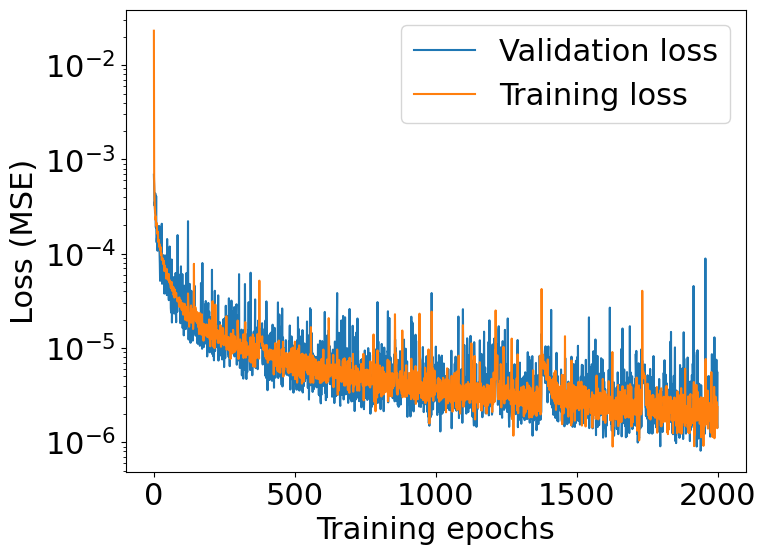

In [127]:
plt.figure(figsize=(8,6))
history.history.keys()
plt.semilogy(history.history['val_loss'])
plt.semilogy(history.history['loss'])
plt.legend(['Validation loss', 'Training loss'])
plt.xlabel('Training epochs')
plt.ylabel('Loss (MSE)')
#plt.savefig(f'./NNresults/Loss/RandomGenerated256x8.jpg', dpi=300)
plt.show()

In [97]:
pd.DataFrame(history.history).loc[(pd.DataFrame(history.history)['val_loss'] == pd.DataFrame(history.history)['val_loss'].min()) | 
                                    (pd.DataFrame(history.history)['loss'] == pd.DataFrame(history.history)['loss'].min())]

,loss,mean_squared_error,val_loss,val_mean_squared_error
1627,9.015279e-07,9.015279e-07,2.632129e-06,2.632129e-06
1939,2.177132e-06,2.177132e-06,8.145551e-07,8.145551e-07


### Network prediction and validation of results

In [33]:
y_predict = model.predict(x_test)
y_pred = pd.DataFrame(y_predict, columns=y_test.columns)

625/625 [==============================] - 3s 3ms/step


Text(0, 0.5, 'y_test')

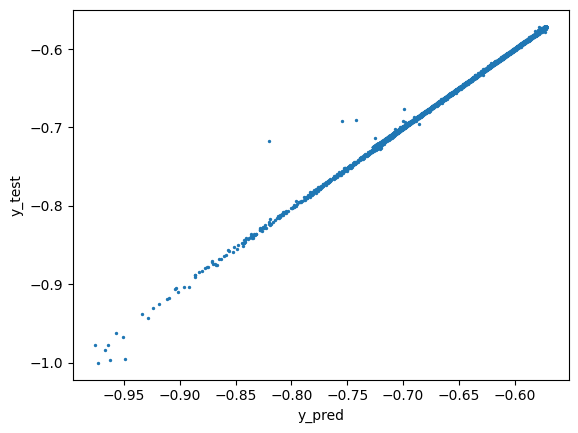

In [34]:
plt.scatter(y_pred['t_Ca'], y_test['t_Ca'], s=2)
plt.xlabel('y_pred')
plt.ylabel('y_test')

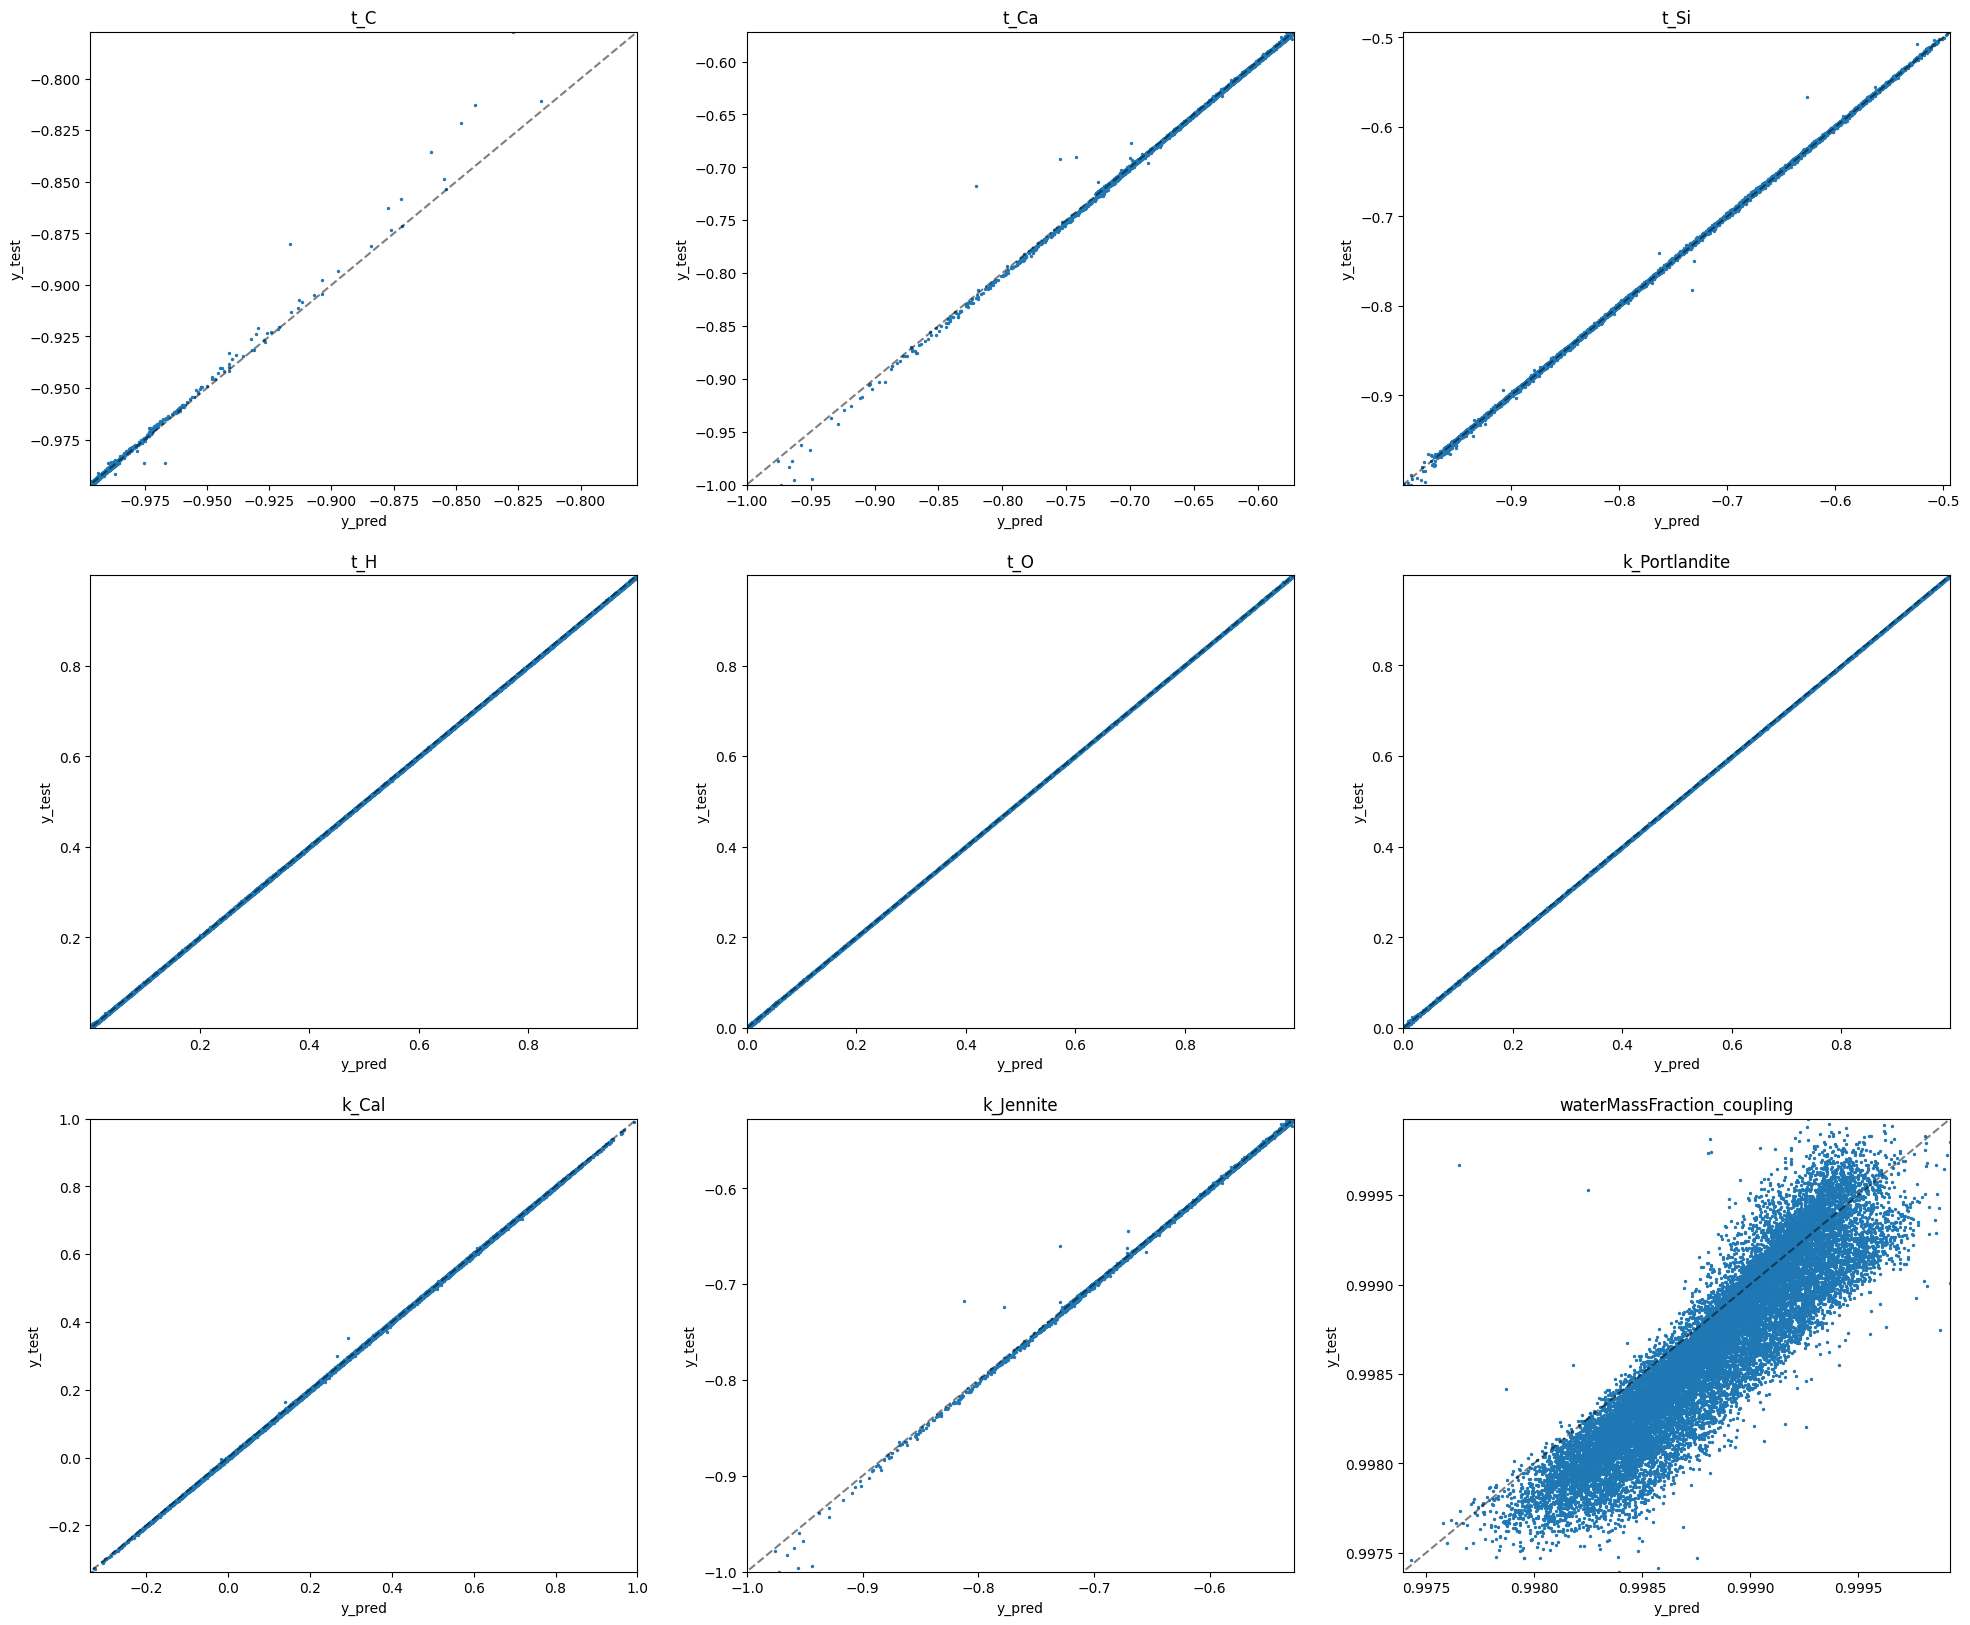

In [35]:
now = '-'.join('_'.join(datetime.now().strftime("%Y-%m-%d %H:%M:%S").split(' ')).split(':'))
r1 = np.linspace(-10,10,100)
fig, ax = plt.subplots(3,3, figsize=(24,20))
i = 0
for axs in ax.flat:
    if i<len(y_test.columns):
        col = y_test.columns[i]
        i+=1
        axs.scatter(y_pred[col], y_test[col], s=2)
        axs.plot(r1,r1,'k--',alpha=0.5)
        lim = [y_test[col].min(),y_test[col].max()]
        axs.set(xlabel='y_pred', ylabel='y_test', xlim=lim, ylim=lim)
        axs.set_title(col)
    else:
        pass
#plt.savefig(f'./NNresults/NNresults_{now}.jpg')

In [36]:
r2_dict = {}
for col in y_pred.columns:
    sum_squares_residuals = sum((y_test[col] - y_pred[col]) ** 2)
    sum_squares = sum((y_test[col] - y_test[col].mean()) ** 2)
    R2 = 1 - sum_squares_residuals / sum_squares
    r2_dict[col] = R2
r2_dict

{'t_C': 0.9881108670483902,
 't_Ca': 0.9995273355980787,
 't_Si': 0.9999075078069495,
 't_H': 0.9999859535922783,
 't_O': 0.9999966112952391,
 'k_Portlandite': 0.9999951598293533,
 'k_Cal': 0.9999234062323031,
 'k_Jennite': 0.9996294714413654,
 'waterMassFraction_coupling': 0.6730467644170406}

In [37]:
data

,C_tr,Ca_tr,Si_tr,H_tr,O_tr,Portlandite,Cal,Jennite,massOfWater,t_C,t_Ca,t_Si,t_H,t_O,k_Portlandite,k_Cal,k_Jennite,waterMassFraction_coupling
0,-0.506252,-0.849372,-0.636032,-0.251434,0.974666,0.000000,0.000000,0.869736,1.0,-0.993822,-0.657769,-0.820827,0.000097,0.869552,0.000000,0.656605,-0.622890,0.998166
1,-0.465507,-0.753055,-0.649056,-0.274796,0.900183,0.024508,0.113514,0.000000,1.0,-0.996781,-0.571591,-0.966006,0.024662,0.000159,0.113471,0.646484,-0.527141,0.998055
2,-0.596108,-0.769979,-0.620414,-0.257897,0.173152,0.658624,0.000000,0.000000,1.0,-0.996780,-0.571591,-0.966056,0.658551,0.000215,0.000069,0.043710,-0.527141,0.999128
3,-0.590281,-0.800476,-0.799175,-0.265117,0.068492,0.183721,0.083101,0.000000,1.0,-0.996780,-0.571591,-0.966059,0.183727,0.000030,0.083149,0.017631,-0.527141,0.999173
4,-0.468497,-0.876468,-0.688911,-0.313427,0.404498,0.823910,0.000000,0.000000,1.0,-0.991848,-0.689705,-0.754826,0.823929,0.000054,0.000000,0.213289,-0.659454,0.998990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.461571,-0.800512,-0.623514,-0.235655,0.296374,0.214309,0.399175,0.000000,1.0,-0.996780,-0.571591,-0.966055,0.214439,0.000208,0.398508,0.063237,-0.527141,0.999094
99996,-0.525198,-0.749314,-0.548592,-0.353750,0.564548,0.285828,0.582830,0.751402,1.0,-0.996780,-0.571591,-0.966026,0.285859,0.751559,0.582495,0.409852,-0.527141,0.998484
99997,-0.492810,-0.931774,-0.545442,-0.328300,0.727439,0.981188,0.000000,0.812589,1.0,-0.986392,-0.709622,-0.545107,0.981143,0.812267,0.000000,0.535307,-0.719802,0.998381
99998,-0.470445,-0.812577,-0.566731,-0.243006,0.184882,0.852967,0.345159,0.942318,1.0,-0.996780,-0.571591,-0.966062,0.852978,0.942321,0.344189,-0.027591,-0.527141,0.999251


In [103]:
pred = pd.concat([x_test, y_pred], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train = pd.concat([x_train, y_train], axis=1)

In [104]:
train_reversed = scaler.inverse_transform(train)
train_reversed = pd.DataFrame(train_reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Cal', 'k_Jennite', 'waterMassFraction_coupling'])
pred_reversed = scaler.inverse_transform(pred)
pred_reversed = pd.DataFrame(pred_reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Cal', 'k_Jennite', 'waterMassFraction_coupling'])
test_reversed = scaler.inverse_transform(test)
test_reversed = pd.DataFrame(test_reversed, columns=['C_tr','Ca_tr','Si_tr','H_tr','O_tr','Portlandite', 'Cal', 'Jennite', 'waterMassFraction',
    't_C','t_Ca','t_Si','t_H','t_O','k_Portlandite', 'k_Cal', 'k_Jennite', 'waterMassFraction_coupling'])

for col in pred_reversed:
    if '_tr' in col:
        pred_reversed[col] = np.exp(pred_reversed[col]) - 1e-10# - data[col].min())
        test_reversed[col] = np.exp(test_reversed[col]) - 1e-10# - data[col].min())
    elif 't_' in col:
        pred_reversed[col] = np.exp(pred_reversed[col]) - 1e-10# - data[col].min())
        test_reversed[col] = np.exp(test_reversed[col]) - 1e-10# - data[col].min())

<Figure size 1000x1000 with 0 Axes>

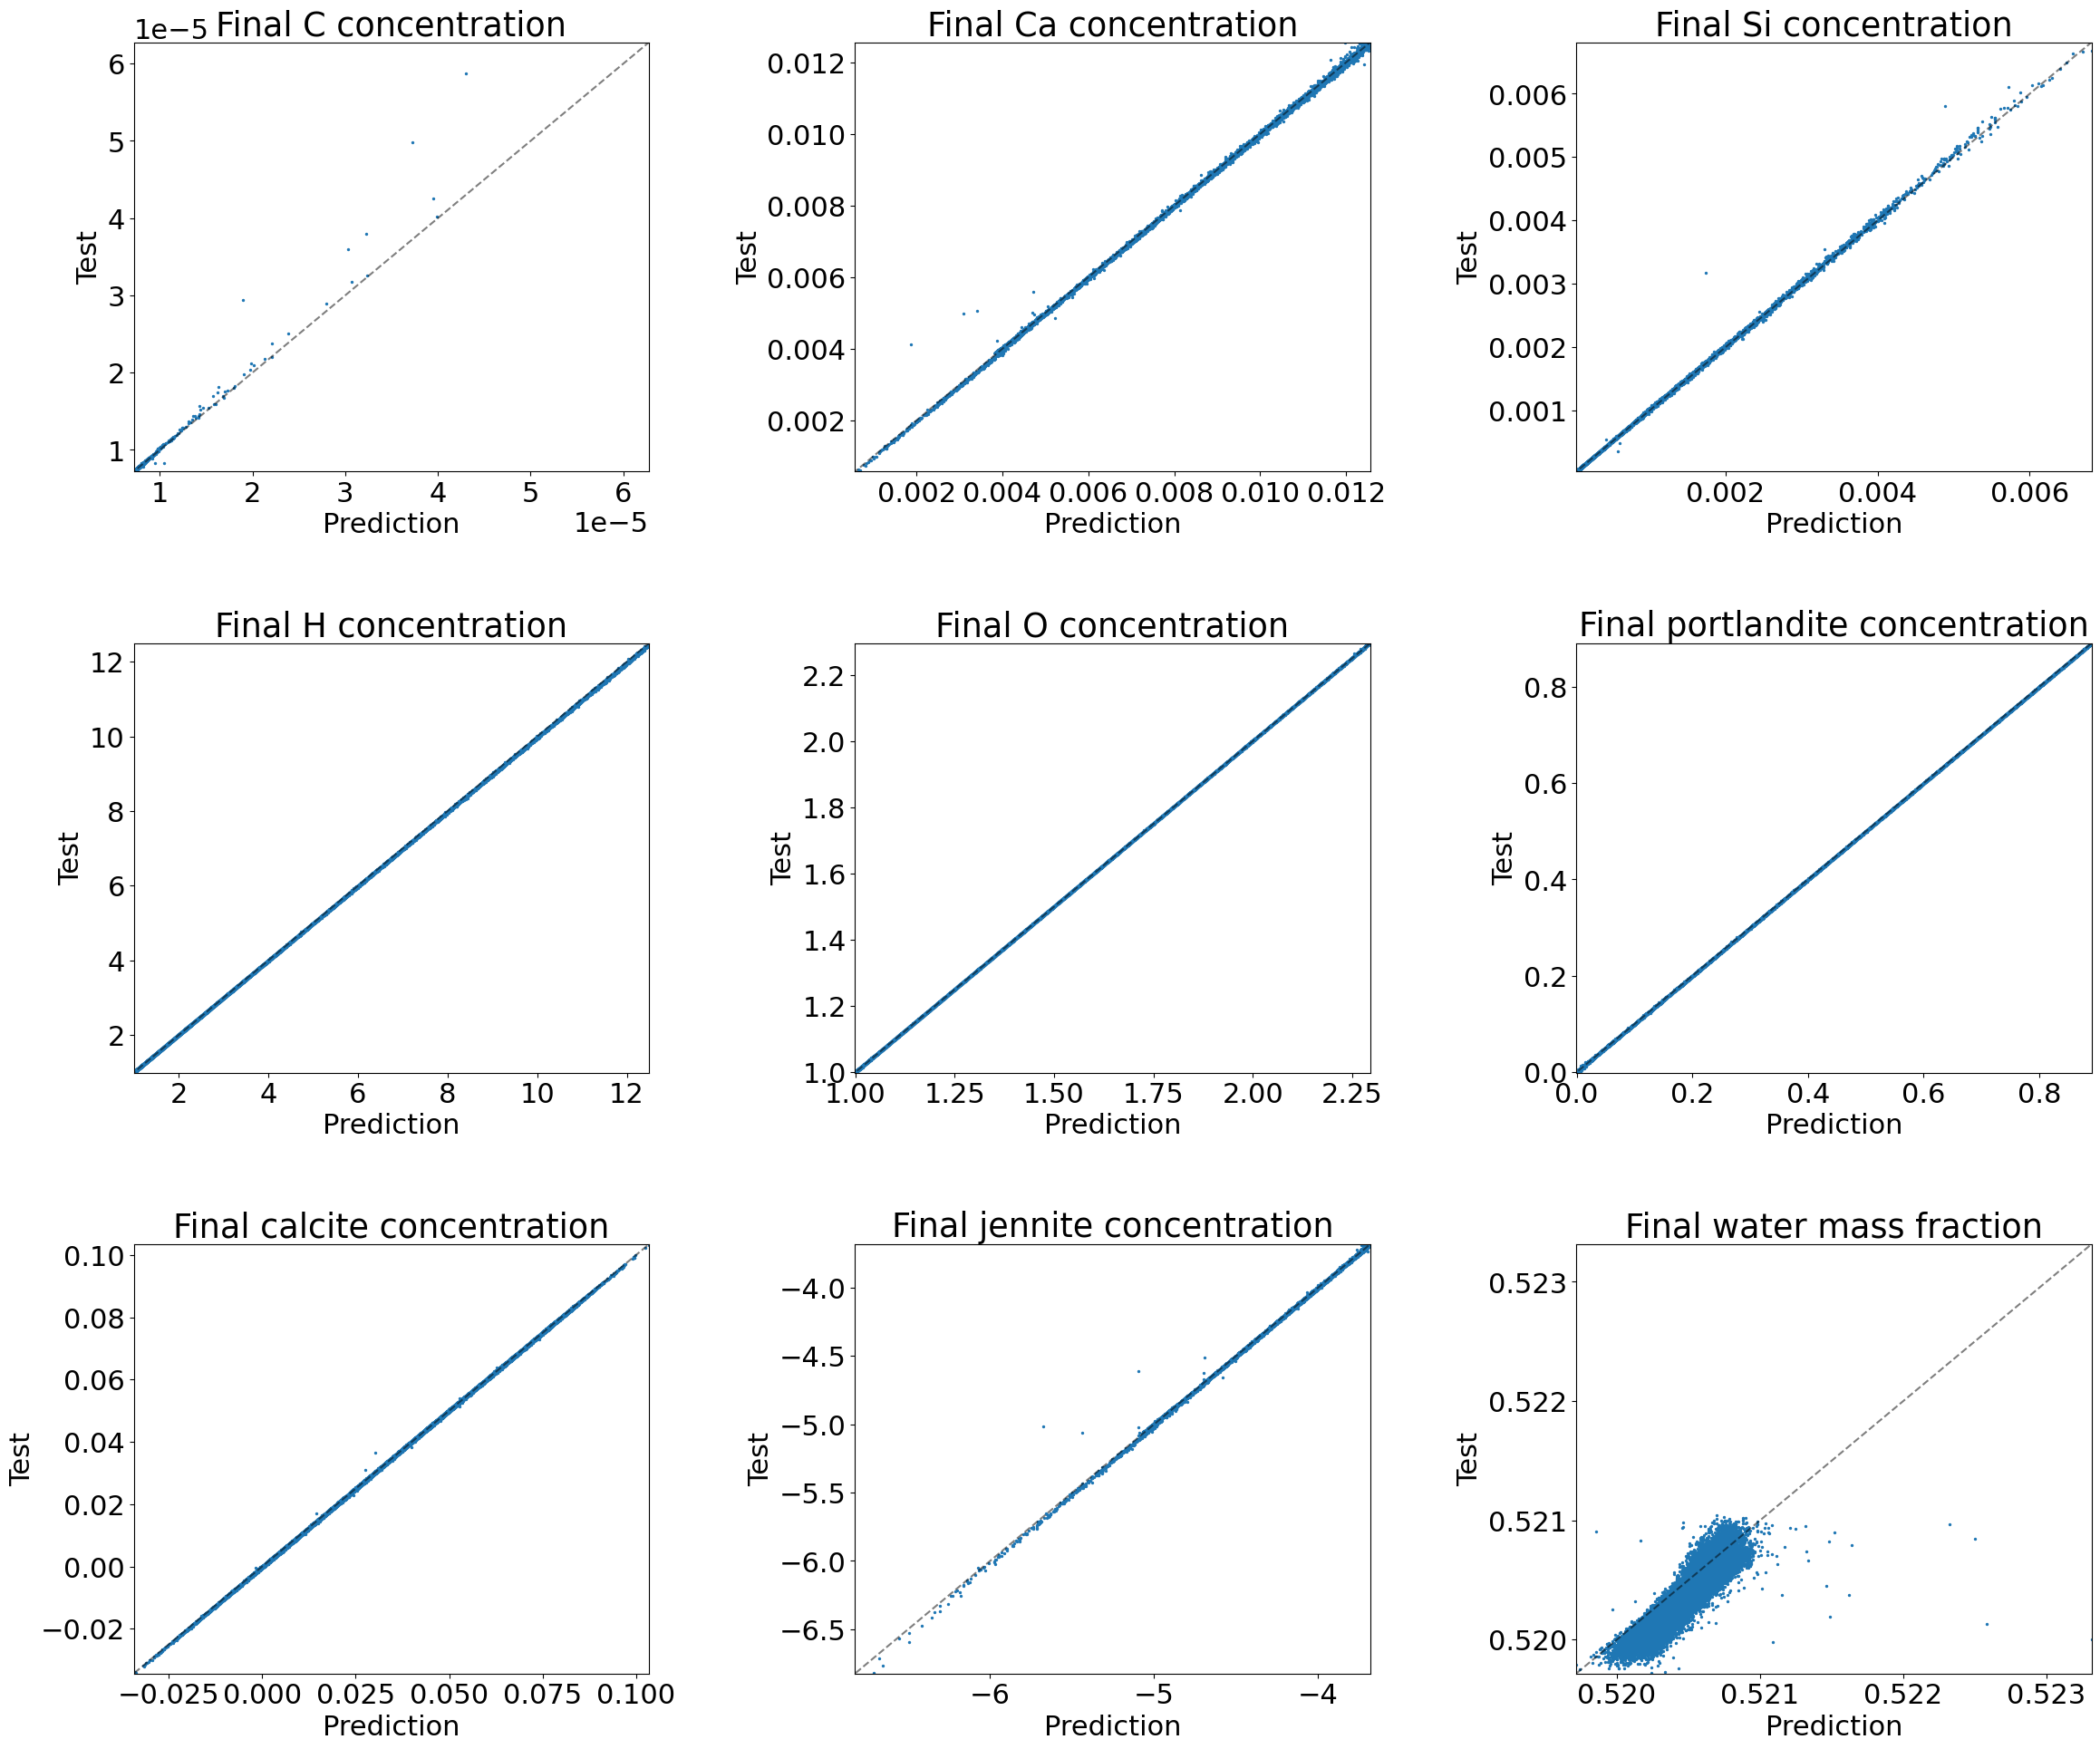

In [126]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
now = '-'.join('_'.join(datetime.now().strftime("%Y-%m-%d %H:%M:%S").split(' ')).split(':'))
r1 = np.linspace(-1000,1000,100)
fig, ax = plt.subplots(3,3, figsize=(24,20))
i = 0
titles = ['Final C concentration', 'Final Ca concentration', 'Final Si concentration', 'Final H concentration', 'Final O concentration',
         'Final portlandite concentration', 'Final calcite concentration', 'Final jennite concentration', 'Final water mass fraction']
for axs in ax.flat:
    if i<len(y_pred.columns):
        col = y_pred.columns[i]
        i+=1
        axs.scatter(pred_reversed[col], test_reversed[col], s=2)
        axs.plot(r1,r1,'k--',alpha=0.5)
        #lim = [min(pred_reversed[col].min(), test_reversed[col].min()),max(pred_reversed[col].max(), test_reversed[col].max())]
        lim = [pred_reversed[col].min(),pred_reversed[col].max()]
        axs.set(xlabel='Prediction', ylabel='Test', xlim=lim, ylim=lim)
        #axs.xaxis.label.set_size(16)
        #axs.yaxis.label.set_size(16)
        axs.set_title(titles[i-1])
    else:
        pass
    plt.subplots_adjust(left=0.075, right=0.975, 
                        top=0.95, bottom=0.05, 
                        wspace=0.4, hspace=0.4)
#plt.savefig(f'./NNresults/NNresults_RTM_{now}.jpg', dpi=300)

In [78]:
r2_dict_reversed = {}
for col in y_test.columns:
    sum_squares_residuals = sum((test_reversed[col] - pred_reversed[col]) ** 2)
    sum_squares = sum((test_reversed[col] - test_reversed[col].mean()) ** 2)
    R2 = 1 - sum_squares_residuals / sum_squares
    r2_dict_reversed[col] = R2
r2_dict_reversed

{'t_C': 0.9065366739726795,
 't_Ca': 0.9997408060980517,
 't_Si': 0.9995596508579032,
 't_H': 0.9999626912485825,
 't_O': 0.9999963034260344,
 'k_Portlandite': 0.9999951598293533,
 'k_Cal': 0.9999234062323031,
 'k_Jennite': 0.9996294714413654,
 'waterMassFraction_coupling': 0.67304676441704}

In [106]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('./result_datasets/random_history.csv')
pred_reversed.to_csv('./result_datasets/random_pred.csv')
test_reversed.to_csv('./result_datasets/random_test.csv')
train_reversed.to_csv('./result_datasets/random_train.csv')

In [101]:
pred_reversed

,C_tr,Ca_tr,Si_tr,H_tr,O_tr,Portlandite,Cal,Jennite,waterMassFraction,t_C,t_Ca,t_Si,t_H,t_O,k_Portlandite,k_Cal,k_Jennite,waterMassFraction_coupling
0,0.003215,0.018732,0.002755,0.001323,1.013166,1.000779,0.000000,0.000000,0.1,0.000007,0.011093,0.000071,2.725414,0.999962,0.000250,0.004926,-3.812321,0.520609
1,0.001292,0.007680,0.004118,0.005896,1.066268,0.977679,0.802364,0.000000,0.1,0.000007,0.012485,0.000056,2.665837,0.999928,0.801419,0.067895,-3.692605,0.520328
2,0.003501,0.016712,0.003769,0.030418,1.048458,0.000000,0.000000,0.392832,0.1,0.000008,0.007298,0.000181,0.999534,1.480986,0.000373,0.016889,-4.236268,0.520639
3,0.000010,0.016846,0.003499,0.035378,1.020783,1.790244,0.000000,0.000000,0.1,0.000007,0.011116,0.000071,5.981691,1.000057,0.000331,0.001624,-3.810857,0.520611
4,0.001672,0.014108,0.002267,0.035889,1.056306,2.007090,0.000000,0.000000,0.1,0.000007,0.008866,0.000115,7.451996,1.000122,0.000218,0.033676,-4.038526,0.520435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.002948,0.017414,0.003227,0.030209,1.013797,1.892798,0.000000,0.000000,0.1,0.000007,0.009274,0.000105,6.657876,0.999964,0.000274,-0.012270,-3.992365,0.520673
19996,0.002631,0.007872,0.001686,0.026941,1.026254,2.228237,0.425662,0.801769,0.1,0.000007,0.012492,0.000056,9.338235,2.227168,0.426321,0.020892,-3.693335,0.520545
19997,0.002897,0.012801,0.003559,0.037003,1.030340,2.148819,0.000000,0.317777,0.1,0.000008,0.004868,0.000536,8.611706,1.373768,0.000102,-0.003258,-4.658227,0.520723
19998,0.001032,0.007225,0.001529,0.007017,1.042356,0.000000,0.000000,0.786484,0.1,0.000008,0.004724,0.000596,1.000832,2.194425,0.000284,0.036747,-4.692338,0.520537
